Etapa 1) Carregar base de dados

Primeiro, precisamos carregar nossos dados e aplicar algumas transformações nas imagens para que estejam alinhadas com os requisitos da rede.

Utilizaremos o módulo torchvision.datasets para carregar os dados de uma pasta. Esse módulo irá percorrer a pasta para dividir os dados em conjuntos de treinamento e validação.

As transformações incluirão recortar as imagens do centro, realizar uma inversão horizontal, normalizar e, por fim, converter as imagens em tensores para uso em Deep Learning.

In [5]:
from __future__ import print_function, division
import os
import time
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

data_dir = "alien_pred"
input_shape = 224
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

#data transformation
data_transforms = {
   'train': transforms.Compose([
       transforms.CenterCrop(input_shape),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
   'validation': transforms.Compose([
       transforms.CenterCrop(input_shape),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
}

image_datasets = {
   x: datasets.ImageFolder(
       os.path.join(data_dir, x),
       transform=data_transforms[x]
   )
   for x in ['train', 'validation']
}

dataloaders = {
   x: torch.utils.data.DataLoader(
       image_datasets[x], batch_size=32,
       shuffle=True, num_workers=4
   )
   for x in ['train', 'validation']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

print(dataset_sizes)
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': 694, 'validation': 200}


Vamos examinar nosso conjunto de dados para Transfer Learning com PyTorch. O procedimento de visualização irá buscar o próximo lote de imagens e rótulos dos carregadores de dados de treinamento e os exibirá usando a biblioteca Matplotlib.

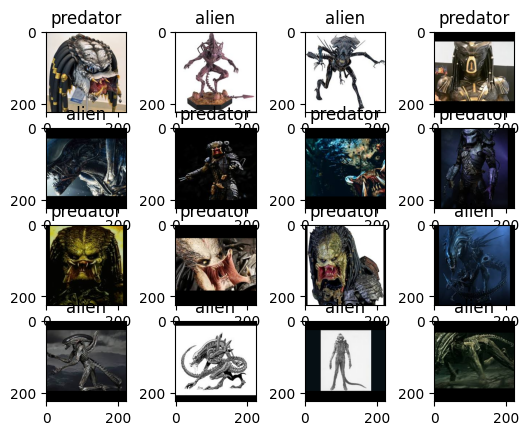

In [6]:
images, labels = next(iter(dataloaders['train']))

rows = 4
columns = 4
fig=plt.figure()
for i in range(16):
   fig.add_subplot(rows, columns, i+1)
   plt.title(class_names[labels[i]])
   img = images[i].numpy().transpose((1, 2, 0))
   img = std * img + mean
   plt.imshow(img)
plt.show()

Etapa 2) Definir modelo

Aqui utilizamos a ResNet18 do módulo torchvision.

Você carregará a ResNet18 com pesos pré-treinados definidos como True usando torchvision.models. Em seguida, congelará as camadas para que elas não sejam ajustadas durante o treinamento. Além disso, você modificará a última camada para uma camada Linear que se ajuste ao nosso problema de duas classes. A função de perda usada será CrossEntropyLoss para classificação multiclasse, e o otimizador escolhido é o SGD com uma taxa de aprendizado de 0,0001 e momentum de 0,9, conforme ilustrado no exemplo de aprendizado de transferência com PyTorch abaixo.

In [7]:
## Load the model based on VGG19
vgg_based = torchvision.models.vgg19(pretrained=True)

## freeze the layers
for param in vgg_based.parameters():
   param.requires_grad = False

# Modify the last layer
number_features = vgg_based.classifier[6].in_features
features = list(vgg_based.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, len(class_names))])
vgg_based.classifier = torch.nn.Sequential(*features)

vgg_based = vgg_based.to(device)

print(vgg_based)

criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(vgg_based.parameters(), lr=0.001, momentum=0.9)

/home/wesley/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wesley/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/wesley/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:12<00:00, 45.4MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Etapa 3) Modelo de treinamento e teste

Utilizaremos várias funções do Tutorial de Transfer Learning do PyTorch para auxiliar no treinamento e na avaliação do nosso modelo.

In [8]:
def train_model(model, criterion, optimizer, num_epochs=25):
   since = time.time()

   for epoch in range(num_epochs):
       print('Epoch {}/{}'.format(epoch, num_epochs - 1))
       print('-' * 10)

       #set model to trainable
       # model.train()

       train_loss = 0

       # Iterate over data.
       for i, data in enumerate(dataloaders['train']):
           inputs , labels = data
           inputs = inputs.to(device)
           labels = labels.to(device)

           optimizer.zero_grad()
          
           with torch.set_grad_enabled(True):
               outputs  = model(inputs)
               loss = criterion(outputs, labels)

           loss.backward()
           optimizer.step()

           train_loss += loss.item() * inputs.size(0)

           print('{} Loss: {:.4f}'.format(
               'train', train_loss / dataset_sizes['train']))
          
   time_elapsed = time.time() - since
   print('Training complete in {:.0f}m {:.0f}s'.format(
       time_elapsed // 60, time_elapsed % 60))

   return model

def visualize_model(model, num_images=6):
   was_training = model.training
   model.eval()
   images_so_far = 0
   fig = plt.figure()

   with torch.no_grad():
       for i, (inputs, labels) in enumerate(dataloaders['validation']):
           inputs = inputs.to(device)
           labels = labels.to(device)

           outputs = model(inputs)
           _, preds = torch.max(outputs, 1)

           for j in range(inputs.size()[0]):
               images_so_far += 1
               ax = plt.subplot(num_images//2, 2, images_so_far)
               ax.axis('off')
               ax.set_title('predicted: {} truth: {}'.format(class_names[preds[j]], class_names[labels[j]]))
               img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
               img = std * img + mean
               ax.imshow(img)

               if images_so_far == num_images:
                   model.train(mode=was_training)
                   return
       model.train(mode=was_training)


Etapa 4) Treinamento e Resultados

Por fim, neste exemplo de Transfer Learning com PyTorch, começaremos o treinamento definindo o número de épocas como 25 e avaliaremos o modelo após o treinamento. Durante cada etapa do treinamento, o modelo receberá a entrada e fará uma previsão da saída. A saída prevista será então usada para calcular a perda. A partir disso, o cálculo da perda realizará a retropropagação para determinar os gradientes, ajustando os pesos e otimizando os parâmetros usando autograd.

Para a visualização, a rede treinada será testada com um lote de imagens para prever os rótulos, e os resultados serão exibidos com a ajuda do Matplotlib.

Epoch 0/24
----------
train Loss: 0.0357
train Loss: 0.0700
train Loss: 0.1061
train Loss: 0.1404
train Loss: 0.1788
train Loss: 0.2101
train Loss: 0.2353
train Loss: 0.2613
train Loss: 0.2820
train Loss: 0.2981
train Loss: 0.3096
train Loss: 0.3398
train Loss: 0.3644
train Loss: 0.3775
train Loss: 0.3908
train Loss: 0.4044
train Loss: 0.4193
train Loss: 0.4361
train Loss: 0.4511
train Loss: 0.4642
train Loss: 0.4819
train Loss: 0.4905
Epoch 1/24
----------
train Loss: 0.0075
train Loss: 0.0143
train Loss: 0.0315
train Loss: 0.0395
train Loss: 0.0524
train Loss: 0.0655
train Loss: 0.0805
train Loss: 0.0994
train Loss: 0.1107
train Loss: 0.1274
train Loss: 0.1392
train Loss: 0.1533
train Loss: 0.1599
train Loss: 0.1719
train Loss: 0.1862
train Loss: 0.1978
train Loss: 0.2048
train Loss: 0.2113
train Loss: 0.2265
train Loss: 0.2391
train Loss: 0.2496
train Loss: 0.2602
Epoch 2/24
----------
train Loss: 0.0133
train Loss: 0.0243
train Loss: 0.0357
train Loss: 0.0484
train Loss: 0.0603
tra

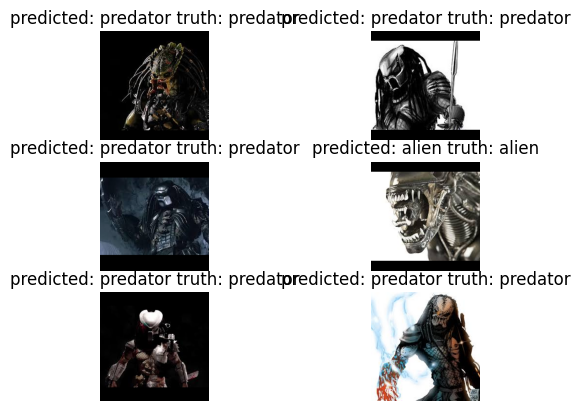

In [9]:
vgg_based = train_model(vgg_based, criterion, optimizer_ft, num_epochs=25)

visualize_model(vgg_based)

plt.show()

Resumo

Usando um modelo pré-treinado para extração de recursos : ao trabalhar com um conjunto de dados pequeno, é uma prática comum aproveitar os recursos aprendidos por um modelo treinado em um conjunto de dados maior no mesmo domínio. Isso é feito instanciando o modelo pré-treinado e adicionando um classificador totalmente conectado no topo. O modelo pré-treinado é "congelado" e apenas os pesos do classificador são atualizados durante o treinamento. Nesse caso, a base convolucional extraiu todos os recursos associados a cada imagem e acabou de treinar um classificador que determina a classe da imagem a partir desse conjunto de recursos extraídos.